In [65]:
# !pip install xgboost
# !pip install imbalanced-learn
# !pip install scikit-learn==1.2.2
# !pip install --upgrade imbalanced-learn

# import imblearn
# print("imblearn version:", imblearn.__version__)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings

#ML Libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest
import xgboost as xgb

warnings.filterwarnings("ignore")

In [67]:
# # Load the provided CSV file
# file_path = "C:\\Users\\KIIT\\Downloads\\Augmented_Fraud_Dataset_Pre.csv"
# df = pd.read_csv(file_path, dtype=str)  # Load as string to preserve formatting

# # Save the cleaned dataset back as a CSV file
# cleaned_file_path = "C:\\Users\\KIIT\\Downloads\\Cleaned_Fraud_Dataset.csv"
# df.to_csv(cleaned_file_path, index=False, encoding='utf-8')

In [68]:
# Data Augmentation

# # Load the original dataset from CSV

# original_csv = 'C:\\Users\\KIIT\\Downloads\\Updated_Fraud.csv'
# df = pd.read_csv(original_csv)
# print("Original dataset shape:", df.shape)

# # excel_file_path = 'C:\\Users\\KIIT\\Downloads\\Fraud data FY 2023-24 for B&CC (2).xlsx'
# # xls = pd.ExcelFile(excel_file_path)
# # df = pd.read_excel(xls, sheet_name='Fraud data')
# # print("Raw Data Shape:", df.shape)
# # print(df.head())

# # Identify numeric and categorical columns
# # (We assume that columns with object dtype are categorical)
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# # Number of synthetic samples you want to generate (adjust as needed)
# n_synthetic = 2000

# synthetic_rows = []

# for i in range(n_synthetic):
#     # Randomly sample one row from the original dataset
#     row = df.sample(n=1, random_state=np.random.randint(10000)).iloc[0].copy()
    
#     # For each numeric column, add Gaussian noise (e.g., 5% of that column's standard deviation)
#     for col in numeric_cols:
#         # Compute noise scale as 5% of the column's standard deviation
#         noise = np.random.normal(0, 0.05 * df[col].std())
#         row[col] = row[col] + noise

#     # For categorical columns, you can either keep the sampled value or randomly pick another value 
#     # from the same column's distribution. Here we keep the sampled value.
    
#     synthetic_rows.append(row)

# df_synthetic = pd.DataFrame(synthetic_rows)

# # Combine original and synthetic data
# df_augmented = pd.concat([df, df_synthetic], ignore_index=True)

# df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

# augmented_csv = 'C:\\Users\\KIIT\\Downloads\\Augmented_Fraud_Dataset_Final_Updated.csv'
# df_augmented.to_csv(augmented_csv, index=False)
# print("Augmented dataset saved to:", augmented_csv)
# print("Augmented dataset shape:", df_augmented.shape)


In [69]:
# Data Loading

# excel_file_path = 'C:\\Users\\KIIT\\Downloads\\Fraud data FY 2023-24 for B&CC (2).xlsx'
# xls = pd.ExcelFile(excel_file_path)
# df_fraud = pd.read_excel(xls, sheet_name='Fraud data')
# print("Raw Data Shape:", df_fraud.shape)
# print(df_fraud.head())

# # Data Loading for CSV file
csv_file_path = "../data/Augmented_Fraud_Dataset_Final_Updated.csv"
df_fraud = pd.read_csv(csv_file_path)
print("Raw Data Shape:", df_fraud.shape)
print(df_fraud.head())


Raw Data Shape: (14776, 24)
   Dummy Policy No  ASSURED_AGE NOMINEE_RELATION  OCCUPATION  \
0      1159.951989    29.860396           Sister     Service   
1       761.927121    36.000000              Son     Service   
2       950.204841    62.107053           Spouse     Retired   
3      1012.041512    53.552922             Wife  Profession   
4      1292.570925    49.337484          Husband   Housewife   

  POLICY SUMASSURED      Premium PREMIUMPAYMENTMODE Annual Income  \
0       3349340.128  417223.2177             Yearly   972309.7517   
1            491939        45969             Yearly       1541742   
2      -129047.0001  203172.0451             Yearly   708014.4195   
3       1035557.725  109874.8143             Yearly   -2293613.74   
4        463708.001  62432.50639             Yearly   206621.5492   

  HOLDERMARITALSTATUS INDIV_REQUIREMENTFLAG  ...  CORRESPONDENCEPOSTCODE  \
0              Single           Non Medical  ...                  700050   
1            divorce

In [70]:
# Data Preprocessing and cleaning

df_cleaned = df_fraud.drop(columns=["Dummy Policy No", "Bank code"], errors="ignore")

date_columns = ["POLICYRISKCOMMENCEMENTDATE", "Date of Death", "INTIMATIONDATE"]
for col in date_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors="coerce")


numeric_cols = ["POLICY SUMASSURED", "Premium", "Annual Income"]
for col in numeric_cols:
    
    df_cleaned[col] = (
        df_cleaned[col]
        .astype(str)
        .str.replace(",", "", regex=False) 
        .str.strip()                       
    )
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce") 

# derived features
df_cleaned["Policy Tenure (Days)"] = (
    df_cleaned["Date of Death"] - df_cleaned["POLICYRISKCOMMENCEMENTDATE"]
).dt.days
df_cleaned["Claim Intimation Lag (Days)"] = (
    df_cleaned["INTIMATIONDATE"] - df_cleaned["Date of Death"]
).dt.days

df_cleaned["POLICY SUMASSURED"] = df_cleaned["POLICY SUMASSURED"].replace(0, np.nan)


df_cleaned["Premium-to-Sum Assured Ratio"] = (
    df_cleaned["Premium"] / df_cleaned["POLICY SUMASSURED"]
)
df_cleaned["Income-to-Sum Assured Ratio"] = (
    df_cleaned["Annual Income"] / df_cleaned["POLICY SUMASSURED"]
)

df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned.dropna(subset=["Premium-to-Sum Assured Ratio", "Income-to-Sum Assured Ratio"], inplace=True)

categorical_columns = [
    "NOMINEE_RELATION", 
    "OCCUPATION", 
    "PREMIUMPAYMENTMODE",
    "HOLDERMARITALSTATUS", 
    "CHANNEL", 
    "Product Type"
]
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

df_cleaned["Fraud_Type"] = df_cleaned["Fraud Category"].fillna("No Fraud")
df_cleaned["Fraudulent"] = 1
df_cleaned.drop(columns=["Fraud Category", "STATUS", "SUB_STATUS"], inplace=True, errors="ignore")

df_cleaned.drop(columns=date_columns, inplace=True, errors="ignore")

print("Cleaned data shape:", df_cleaned.shape)
print(df_cleaned.head())


Cleaned data shape: (14033, 51)
   ASSURED_AGE  POLICY SUMASSURED       Premium  Annual Income  \
0    29.860396       3.349340e+06  417223.21770   9.723098e+05   
1    36.000000       4.919390e+05   45969.00000   1.541742e+06   
2    62.107053      -1.290470e+05  203172.04510   7.080144e+05   
3    53.552922       1.035558e+06  109874.81430  -2.293614e+06   
4    49.337484       4.637080e+05   62432.50639   2.066215e+05   

  INDIV_REQUIREMENTFLAG  Policy Term  Policy Payment Term CORRESPONDENCECITY  \
0           Non Medical    15.712919             9.866811           Calcutta   
1           Non Medical    30.000000            20.000000              GODDA   
2           Non Medical    14.521743             9.996692            BHIWANI   
3           Non Medical    12.422285             9.890028             Kanpur   
4               Medical    15.417569             9.986136             Badaun   

  CORRESPONDENCESTATE CORRESPONDENCEPOSTCODE  ...  \
0         West Bengal                


----- DATA OVERVIEW -----
Shape: (14033, 51)

Head:
    ASSURED_AGE  POLICY SUMASSURED       Premium  Annual Income  \
0    29.860396       3.349340e+06  417223.21770   9.723098e+05   
1    36.000000       4.919390e+05   45969.00000   1.541742e+06   
2    62.107053      -1.290470e+05  203172.04510   7.080144e+05   
3    53.552922       1.035558e+06  109874.81430  -2.293614e+06   
4    49.337484       4.637080e+05   62432.50639   2.066215e+05   

  INDIV_REQUIREMENTFLAG  Policy Term  Policy Payment Term CORRESPONDENCECITY  \
0           Non Medical    15.712919             9.866811           Calcutta   
1           Non Medical    30.000000            20.000000              GODDA   
2           Non Medical    14.521743             9.996692            BHIWANI   
3           Non Medical    12.422285             9.890028             Kanpur   
4               Medical    15.417569             9.986136             Badaun   

  CORRESPONDENCESTATE CORRESPONDENCEPOSTCODE  ...  \
0         West 

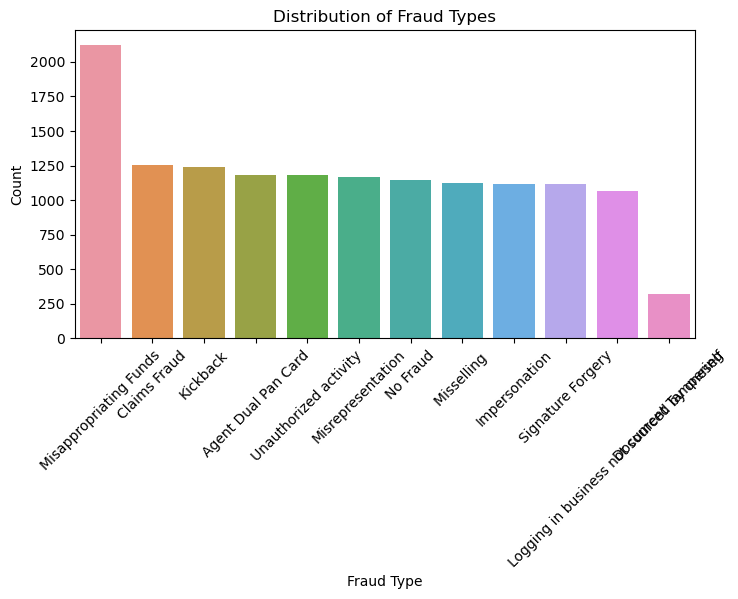

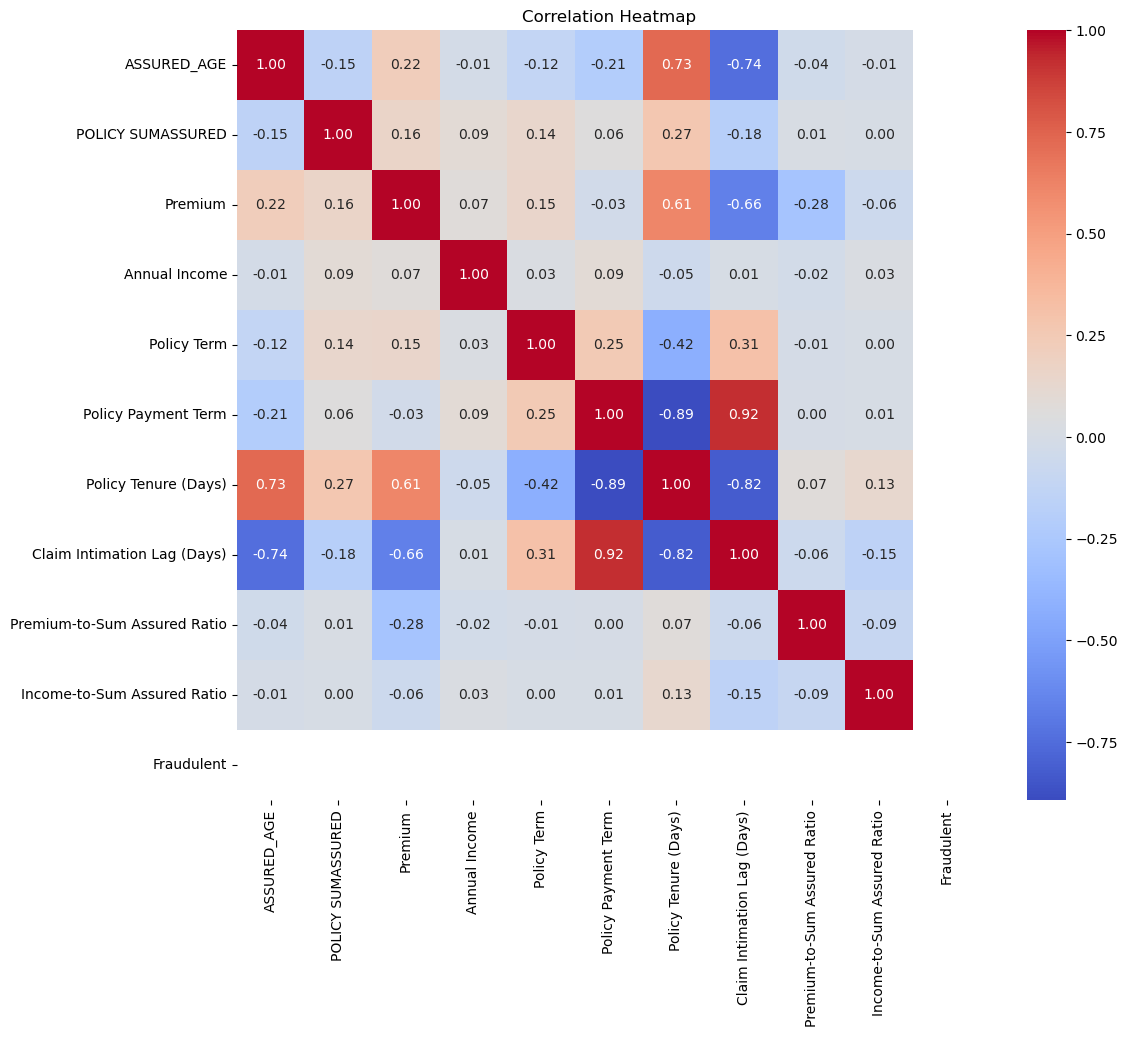

In [71]:
# EDA

def perform_eda(df):
    print("\n----- DATA OVERVIEW -----")
    print("Shape:", df.shape)
    print("\nHead:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    print("\nSummary Statistics:\n", df.describe())
    
    missing = df.isnull().sum()
    print("\nMissing Values in Cleaned Data:\n", missing[missing > 0])
    
    # plt.figure(figsize=(6,4))
    # sns.countplot(x='Fraudulent', data=df)
    # plt.title("Distribution of Fraudulent Claims (Binary)")
    # plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
    # plt.ylabel("Count")
    # plt.show()
    
    plt.figure(figsize=(8,4))
    order = df['Fraud_Type'].value_counts().index
    sns.countplot(data=df, x='Fraud_Type', order=order)
    plt.title("Distribution of Fraud Types")
    plt.xlabel("Fraud Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    plt.figure(figsize=(12,10))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()
    
    # ratio_cols = ['Premium-to-Sum Assured Ratio', 'Income-to-Sum Assured Ratio']
    # df[ratio_cols].hist(bins=20, figsize=(10,4))
    # plt.suptitle("Distribution of Financial Ratios")
    # plt.show()
    
    # if 'Policy Tenure (Days)' in df.columns:
    #     plt.figure(figsize=(8,4))
    #     sns.boxplot(x='Fraudulent', y='Policy Tenure (Days)', data=df)
    #     plt.title("Policy Tenure (Days) by Fraudulent Status")
    #     plt.show()

perform_eda(df_cleaned)

In [72]:
# Splitting and Encoding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features = df_cleaned.select_dtypes(include=[np.number]).drop(['Fraudulent'], axis=1)

features = features.drop(['Policy Tenure (Days)', 'Claim Intimation Lag (Days)'], axis=1, errors='ignore')

# multi-class target.
target_raw = df_cleaned['Fraud_Type']

# threshold for rare classes
threshold = 5
freq = target_raw.value_counts()
target_raw = target_raw.apply(lambda x: "Other" if freq[x] < threshold else x)

print("New target frequencies after grouping rare classes:")
print(target_raw.value_counts())

# Label encode the target
le = LabelEncoder()
target = le.fit_transform(target_raw)

print("\nUnique fraud types and their labels:")
for class_label, class_name in zip(np.unique(target), le.inverse_transform(np.unique(target))):
    print(f"{class_label}: {class_name}")

print("\nOverall target distribution:")
print(pd.Series(target).value_counts())


X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.3, random_state=42, stratify=target)

print("\nTraining target distribution (after splitting):")
print(pd.Series(y_train).value_counts())

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

min_samples = np.min(pd.Series(y_train).value_counts())

k_neighbors = max(1, min(5, min_samples - 1))
print("\nUsing k_neighbors =", k_neighbors, "for SMOTE.")

try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("\nAfter SMOTE, training target distribution:")
    print(pd.Series(y_train_bal).value_counts())
except ImportError:
    print("imblearn is not installed. Please install it via 'pip install imbalanced-learn' to use SMOTE.")


New target frequencies after grouping rare classes:
Fraud_Type
Misappropriating Funds                        2123
Claims Fraud                                  1251
Kickback                                      1242
Agent Dual Pan Card                           1184
Unauthorized activity                         1181
Misrepresentation                             1167
No Fraud                                      1146
Misselling                                    1127
Impersonation                                 1114
Signature Forgery                             1113
Logging in business not sourced by oneself    1065
Document Tampering                             320
Name: count, dtype: int64

Unique fraud types and their labels:
0: Agent Dual Pan Card
1: Claims Fraud
2: Document Tampering
3: Impersonation
4: Kickback
5: Logging in business not sourced by oneself
6: Misappropriating Funds
7: Misrepresentation
8: Misselling 
9: No Fraud
10: Signature Forgery
11: Unauthorized activity

Ov

In [73]:
# XG Boost model supervised training

import xgboost as xgb


num_classes = len(le.classes_)
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
clf.fit(X_train_bal, y_train_bal)

# softprob model for probability estimates
clf_prob = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
clf_prob.fit(X_train_bal, y_train_bal)

print("Models (clf and clf_prob) trained successfully.")

Models (clf and clf_prob) trained successfully.


Test Set Accuracy: 0.9786223277909739

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       0.97      0.97      0.97       375
           2       0.96      0.84      0.90        96
           3       0.99      0.98      0.98       334
           4       0.99      1.00      0.99       373
           5       1.00      1.00      1.00       320
           6       0.97      0.99      0.98       637
           7       0.91      0.93      0.92       350
           8       0.98      0.99      0.98       338
           9       1.00      0.99      0.99       344
          10       0.97      0.96      0.97       334
          11       1.00      0.99      1.00       354

    accuracy                           0.98      4210
   macro avg       0.98      0.97      0.97      4210
weighted avg       0.98      0.98      0.98      4210

Confusion Matrix:
[[355   0   0   0   0   0   0   0   0   0   0   0]
 [

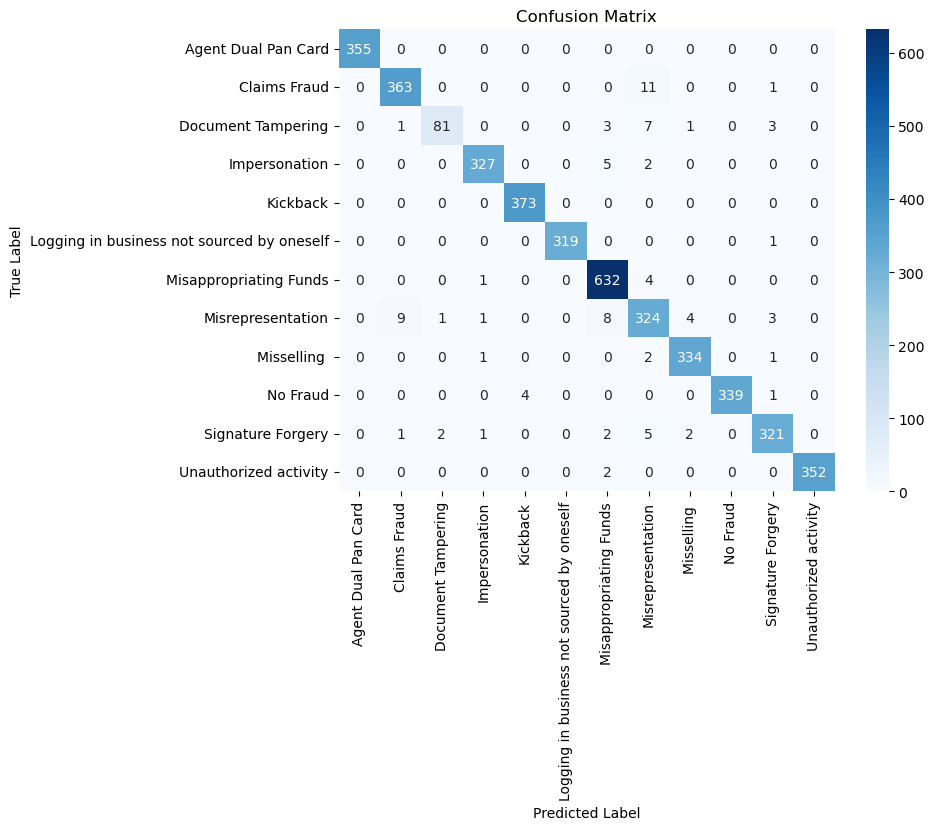

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=le.inverse_transform(np.arange(num_classes)),
    yticklabels=le.inverse_transform(np.arange(num_classes))
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Inverted IF Accuracy (binary, default predict): 0.8958170027791634

Inverted IF Classification Report (default):
              precision    recall  f1-score   support

    No Fraud       0.34      0.29      0.31      1146
       Fraud       0.94      0.95      0.94     12887

    accuracy                           0.90     14033
   macro avg       0.64      0.62      0.63     14033
weighted avg       0.89      0.90      0.89     14033


Inverted IF Confusion Matrix (default):
[[  329   817]
 [  645 12242]]


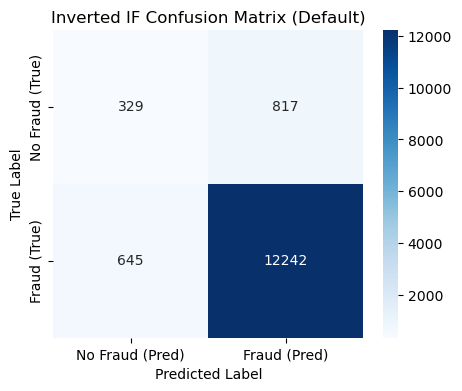

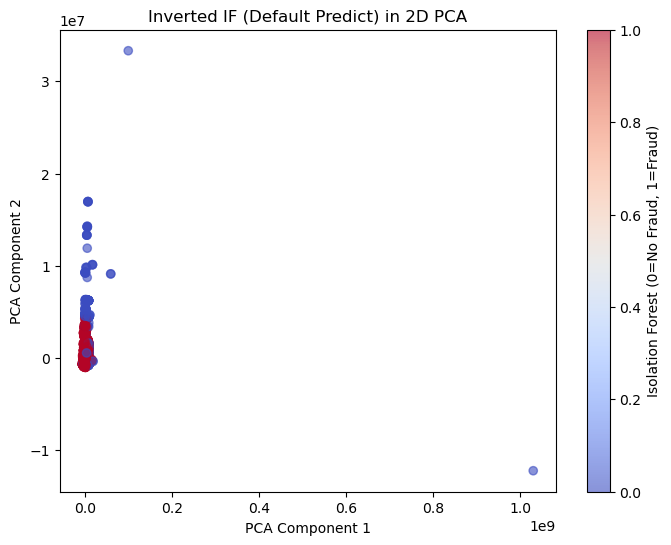

In [75]:
# Isolation Forest model unsupervised training

from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA


df_fraud = df_cleaned[df_cleaned["Fraud_Type"] != "No Fraud"]
df_no_fraud = df_cleaned[df_cleaned["Fraud_Type"] == "No Fraud"]

X_fraud = df_fraud.select_dtypes(include=[np.number]).copy()

cols_to_drop = ["Fraudulent", "Policy Tenure (Days)", "Claim Intimation Lag (Days)"]
X_fraud.drop(columns=cols_to_drop, inplace=True, errors="ignore")

X_fraud = X_fraud.fillna(X_fraud.median())

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05, 
    random_state=42
)
iso.fit(X_fraud)

X_all = df_cleaned.select_dtypes(include=[np.number]).copy()
X_all.drop(columns=cols_to_drop, inplace=True, errors="ignore")

common_cols = X_fraud.columns.intersection(X_all.columns)
X_fraud = X_fraud[common_cols]
X_all = X_all[common_cols].fillna(X_all[common_cols].median())

# Evaluate default iso.predict(...) for reference
iso_preds = iso.predict(X_all)
iso_preds_binary = np.where(iso_preds == 1, 1, 0)

# Binary ground truth: 0 = No Fraud, 1 = Fraud
y_binary = np.where(df_cleaned["Fraud_Type"] == "No Fraud", 0, 1)

iso_acc = accuracy_score(y_binary, iso_preds_binary)
print("Inverted IF Accuracy (binary, default predict):", iso_acc)

print("\nInverted IF Classification Report (default):")
print(classification_report(y_binary, iso_preds_binary, target_names=["No Fraud", "Fraud"]))

cm = confusion_matrix(y_binary, iso_preds_binary)
print("\nInverted IF Confusion Matrix (default):")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Fraud (Pred)", "Fraud (Pred)"],
            yticklabels=["No Fraud (True)", "Fraud (True)"])
plt.title("Inverted IF Confusion Matrix (Default)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2D PCA cluster visualization
pca = PCA(n_components=2, random_state=42)
X_all_pca = pca.fit_transform(X_all)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_all_pca[:,0],
    X_all_pca[:,1],
    c=iso_preds_binary,  # color by 0/1
    cmap='coolwarm',
    alpha=0.6
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Inverted IF (Default Predict) in 2D PCA")
plt.colorbar(scatter, label="Isolation Forest (0=No Fraud, 1=Fraud)")
plt.show()


Inverted Isolation Forest decision score: 0.0732

Fraud Detected: Kickback

Predicted probabilities:
   Agent Dual Pan Card  Claims Fraud  Document Tampering  Impersonation  \
0         2.979408e-07      0.000043             0.00002   1.644946e-07   

   Kickback  Logging in business not sourced by oneself  \
0  0.999776                                    0.000002   

   Misappropriating Funds  Misrepresentation  Misselling   No Fraud  \
0                 0.00009           0.000045     0.000003  0.000015   

   Signature Forgery  Unauthorized activity  
0           0.000005           5.062805e-07  


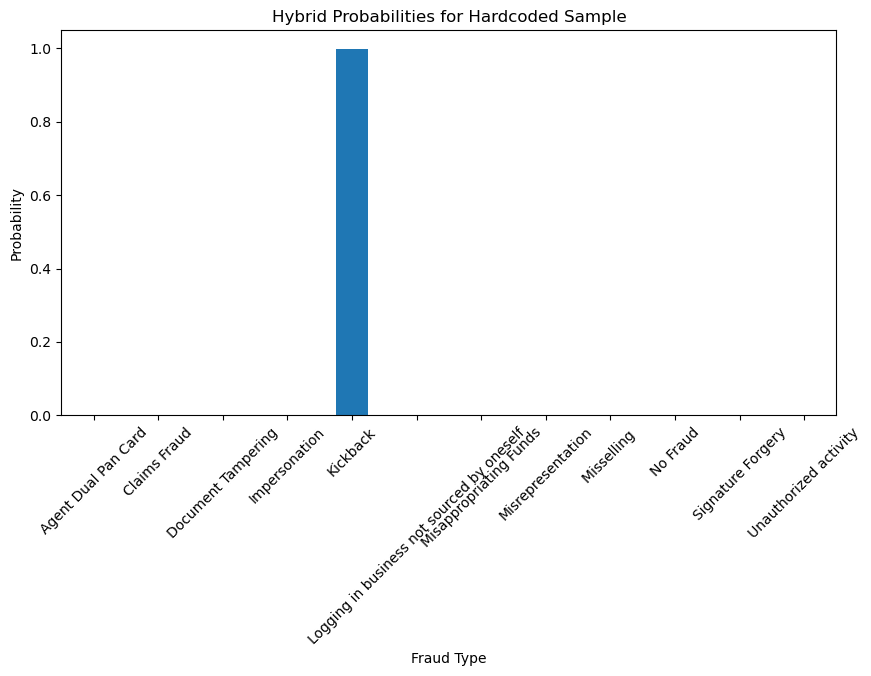

In [76]:
# Hybrid Model and Hard Code Prediction

def hybrid_predict_proba_inverted(
    sample_features,
    iso_model,
    xgb_model,
    label_encoder,
    common_cols,
    X_train,
    decision_threshold=0.02, 
    num_classes=None
):
    """
    1) Align columns => fill missing
    2) iso_model.decision_function(...) => if score >= decision_threshold => FRAUD => XGBoost
       else => NO FRAUD
    3) Return (pred_label, probs_df, fraud_exists)
    """
    sample_features = sample_features[common_cols].copy()
    sample_features = sample_features.fillna(X_train[common_cols].median())

    # Inverted Isolation Forest score
    iso_score = iso_model.decision_function(sample_features)[0]
    print(f"Inverted Isolation Forest decision score: {iso_score:.4f}")

    if iso_score >= decision_threshold:
        # FRAUD => use XGBoost to classify fraud type
        probs = xgb_model.predict_proba(sample_features)
        if num_classes is None:
            num_classes = len(label_encoder.classes_)
        # probability DataFrame
        probs_df = pd.DataFrame(probs, columns=label_encoder.inverse_transform(np.arange(num_classes)))

        pred_label_num = xgb_model.predict(sample_features)
        pred_label = label_encoder.inverse_transform(pred_label_num)[0]
        return pred_label, probs_df, True
    else:
        # NO FRAUD
        if num_classes is None:
            num_classes = len(label_encoder.classes_)
        prob_dict = {cls: 0.0 for cls in label_encoder.inverse_transform(np.arange(num_classes))}
        prob_dict["No Fraud"] = 1.0
        return "No Fraud", pd.DataFrame([prob_dict]), False


# ----- Hardcoded Sample Prediction -----
hardcoded_sample = X_train[common_cols].median().to_frame().T

overrides = {
    # Core numeric features
    'ASSURED_AGE': 59.20221257,
    'POLICY SUMASSURED': 1055799.635,
    'Premium': 109360.6947,
    'Annual Income': 43320.56362,
    'Policy Term': 9.879896519,
    'Policy Payment Term': 2.824662067,

    # Nominee: "Son"
    'NOMINEE_RELATION_Son': 1,
    # Turn off other nominee flags if needed
    'NOMINEE_RELATION_Mother': 0,
    'NOMINEE_RELATION_Husband': 0,
    'NOMINEE_RELATION_Wife': 0,

    # Occupation: "Retired"
    'OCCUPATION_Retired': 1,
    # Turn off other occupation flags
    'OCCUPATION_Service': 0,
    'OCCUPATION_Business': 0,
    'OCCUPATION_Profession': 0,
    # etc. for any other occupation dummies

    # Payment mode: "Yearly"
    'PREMIUMPAYMENTMODE_Yearly': 1,
    # Turn off other payment mode flags
    'PREMIUMPAYMENTMODE_Quarterly': 0,
    'PREMIUMPAYMENTMODE_Monthly': 0,
    'PREMIUMPAYMENTMODE_Single': 0,

    # Marital status: "Married"
    'HOLDERMARITALSTATUS_Married': 1,
    'HOLDERMARITALSTATUS_Single': 0,
    'HOLDERMARITALSTATUS_divorced': 0,
    'HOLDERMARITALSTATUS_widowed': 0,

    # Requirement Flag: "Medical"
    'INDIV_REQUIREMENTFLAG_Medical': 1,
    'INDIV_REQUIREMENTFLAG_Non Medical': 0,

    # Product Type: "ULIP"
    'Product Type_ULIP': 1,
    'Product Type_Traditional': 0,
    'Product Type_Variable': 0,

    # Channel: "Retail Agency"
    'CHANNEL_Retail Agency': 1,
    # Turn off other channel flags
    # e.g. 'CHANNEL_Bancassurance': 0,
    #      'CHANNEL_Institutional Alliance': 0,
}




for col, val in overrides.items():
    if col in hardcoded_sample.columns:
        hardcoded_sample.loc[:, col] = val

# Predict using the hybrid model
predicted_label, probs_df, fraud_exists = hybrid_predict_proba_inverted(
    sample_features=hardcoded_sample,
    iso_model=iso,
    xgb_model=clf_prob,
    label_encoder=le,
    common_cols=common_cols,
    X_train=X_train,
    num_classes=num_classes
)

if fraud_exists:
    print("\nFraud Detected:", predicted_label)
else:
    print("\nNo Fraud Detected")

print("\nPredicted probabilities:")
print(probs_df)

# Visualize probabilities
probs_df.T.plot(kind='bar', legend=False, figsize=(10,5))
plt.xlabel("Fraud Type")
plt.ylabel("Probability")
plt.title("Hybrid Probabilities for Hardcoded Sample")
plt.xticks(rotation=45)
plt.show()



Random sample from X_test (index=14524):
       ASSURED_AGE  POLICY SUMASSURED      Premium  Annual Income  \
14524    53.312525        802513.8668  92222.27821   -2659537.969   

       Policy Term  Policy Payment Term  Premium-to-Sum Assured Ratio  \
14524    11.708663             9.992701                      0.114917   

       Income-to-Sum Assured Ratio  
14524                    -3.314009  
Inverted Isolation Forest decision score: 0.1386

Fraud Detected: Misappropriating Funds

Predicted probabilities:
   Agent Dual Pan Card  Claims Fraud  Document Tampering  Impersonation  \
0              0.00002       0.00003            0.000051       0.000026   

   Kickback  Logging in business not sourced by oneself  \
0  0.000048                                    0.000024   

   Misappropriating Funds  Misrepresentation  Misselling   No Fraud  \
0                0.991847            0.00614     0.000056  0.000015   

   Signature Forgery  Unauthorized activity  
0           0.001617    

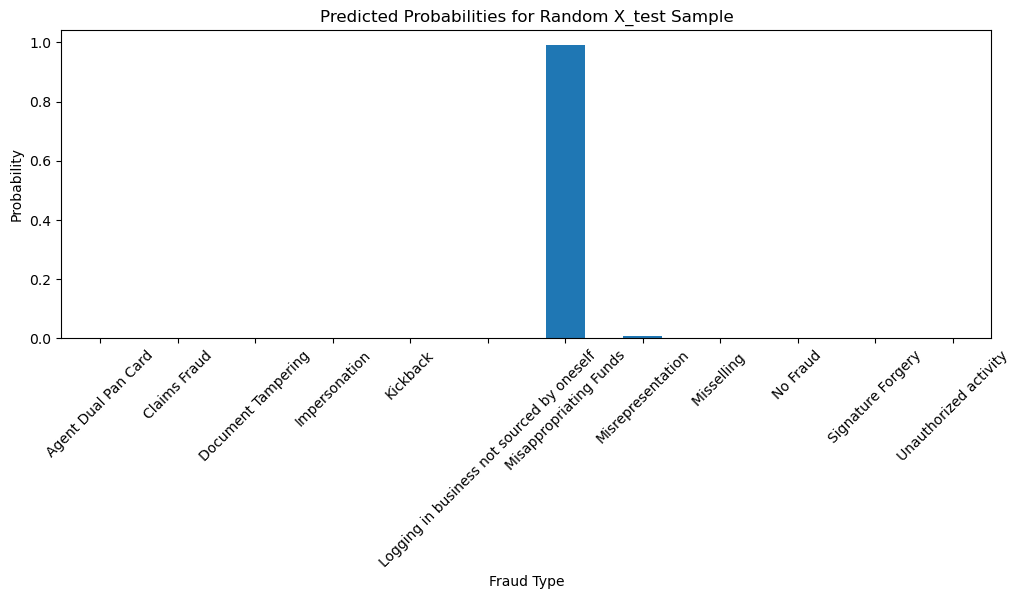

In [77]:
# Random sample Prediction

def random_hybrid_prediction_from_test(
    X_test,
    iso_model,
    xgb_model,
    label_encoder,
    common_cols,
    X_train,
    num_classes=None
):
    """
    1) Randomly pick a single row from X_test.
    2) Align the sample's columns with common_cols and fill missing.
    3) Use the hybrid_predict_proba_inverted function to label it (fraud or no fraud).
    4) Print and visualize the resulting probabilities.
    """

    # random index from X_test
    random_idx = np.random.choice(X_test.index)
    random_sample = X_test.loc[[random_idx]].copy()

    print("\nRandom sample from X_test (index={}):".format(random_idx))
    print(random_sample)

    pred_label, probs_df, is_fraud = hybrid_predict_proba_inverted(
        sample_features=random_sample,
        iso_model=iso_model,
        xgb_model=xgb_model,
        label_encoder=label_encoder,
        common_cols=common_cols,
        X_train=X_train,
        num_classes=num_classes
    )

    if is_fraud:
        print("\nFraud Detected:", pred_label)
    else:
        print("\nNo Fraud Detected")

    print("\nPredicted probabilities:")
    print(probs_df)

    probs_df.T.plot(kind='bar', legend=False, figsize=(12,4))
    plt.xlabel("Fraud Type")
    plt.ylabel("Probability")
    plt.title("Predicted Probabilities for Random X_test Sample")
    plt.xticks(rotation=45)
    plt.show()

random_hybrid_prediction_from_test(
    X_test=X_test,
    iso_model=iso,
    xgb_model=clf_prob,
    label_encoder=le,
    common_cols=common_cols,
    X_train=X_train,
    num_classes=len(le.classes_)
)


Inverted Isolation Forest decision score: 0.0655
Inverted Isolation Forest decision score: 0.1450
Inverted Isolation Forest decision score: 0.1707
Inverted Isolation Forest decision score: 0.1524
Inverted Isolation Forest decision score: 0.1563

Picked 5 random samples from X_test. Predictions:
Sample 0: Predicted = Misselling 
Sample 1: Predicted = Claims Fraud
Sample 2: Predicted = Misappropriating Funds
Sample 3: Predicted = Misrepresentation
Sample 4: Predicted = Misappropriating Funds

Predicted Probabilities:
   Agent Dual Pan Card  Claims Fraud  Document Tampering  Impersonation  \
0         2.865793e-07  9.188269e-08            0.000010   4.289525e-07   
0         1.830925e-06  9.990757e-01            0.000009   3.585081e-06   
0         2.636657e-06  2.322750e-05            0.000003   4.999829e-05   
0         1.426411e-06  2.670728e-06            0.000025   1.581625e-06   
0         5.422372e-06  2.496347e-05            0.000010   9.333280e-05   

       Kickback  Logging in 

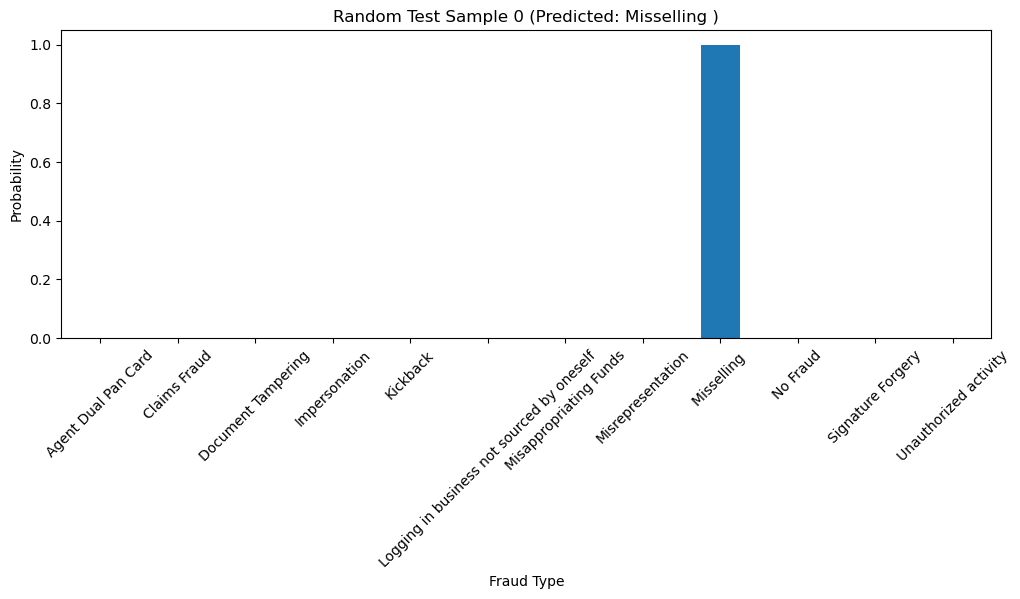

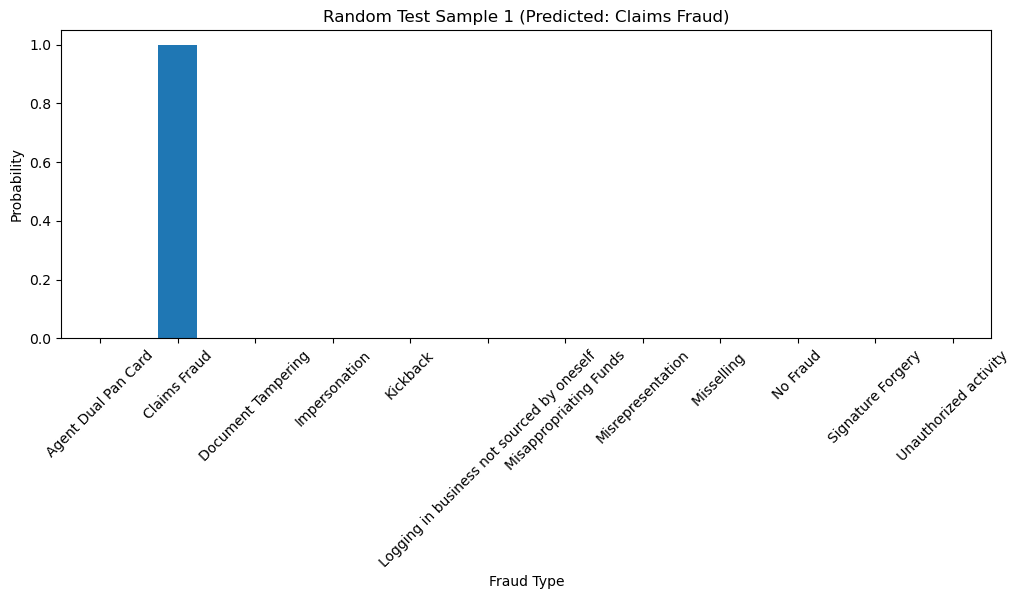

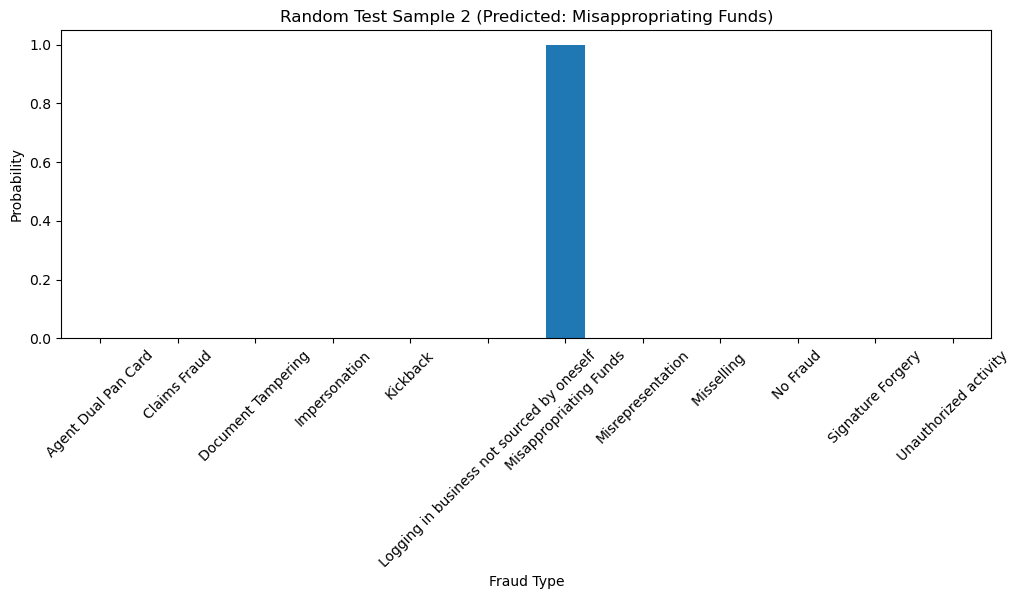

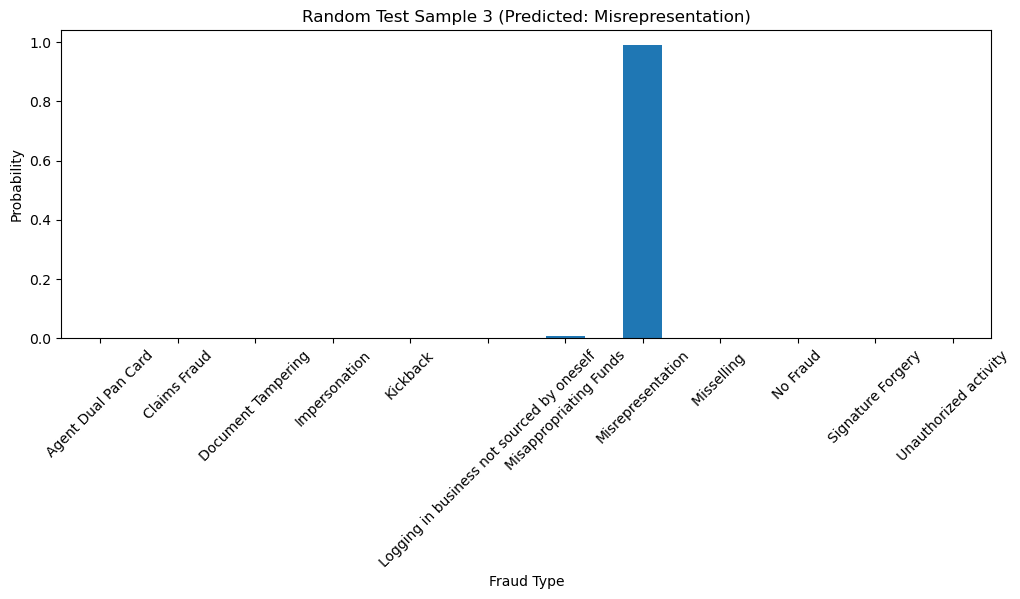

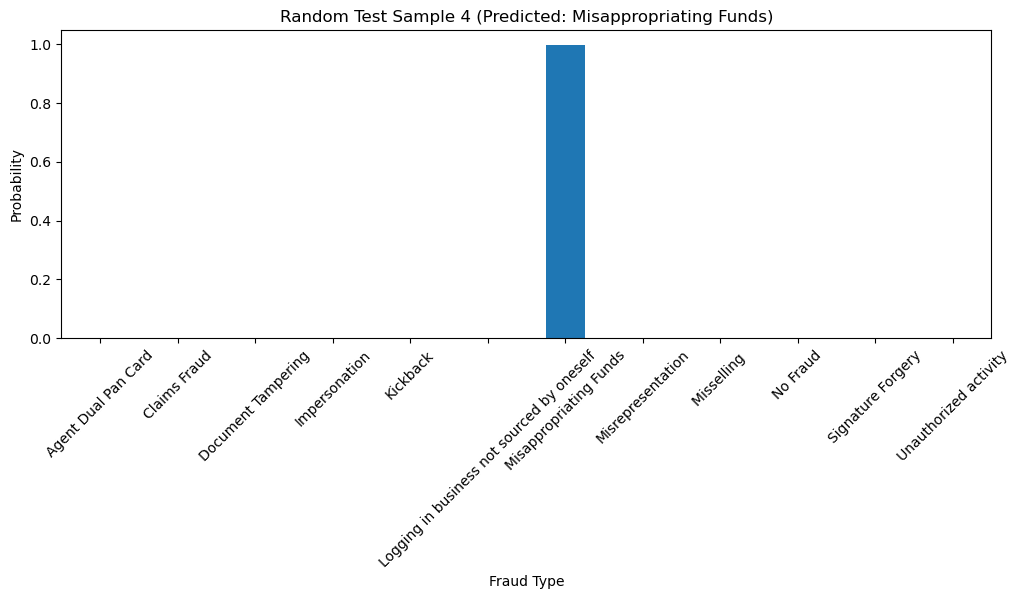

In [78]:
# Multiple Random Sample Prediction
import random

def multiple_hybrid_predictions_from_test(
    X_test,
    iso_model,
    xgb_model,
    label_encoder,
    common_cols,
    X_train,
    n=5,                 
    num_classes=None
):
    """
    1) Pick n random samples from X_test.
    2) For each sample, call the hybrid_predict_proba_inverted function.
    3) Print and plot the results.
    """
    
    random_indices = random.sample(list(X_test.index), n)
    X_test_samples = X_test.loc[random_indices].copy().reset_index(drop=True)

    predicted_labels = []
    probs_list = []

    for i in range(n):
        sample_features = X_test_samples.iloc[[i]].copy()
        
        pred_label, probs_df, is_fraud = hybrid_predict_proba_inverted(
            sample_features=sample_features,
            iso_model=iso_model,
            xgb_model=xgb_model,
            label_encoder=label_encoder,
            common_cols=common_cols,
            X_train=X_train,
            num_classes=num_classes
        )
        
        predicted_labels.append(pred_label)
        probs_list.append(probs_df.iloc[0]) 

    probs_df_all = pd.DataFrame(probs_list)

    print(f"\nPicked {n} random samples from X_test. Predictions:")
    for i in range(n):
        print(f"Sample {i}: Predicted = {predicted_labels[i]}")
    
    print("\nPredicted Probabilities:")
    print(probs_df_all)


    for i in range(n):
        plt.figure(figsize=(12,4))
        probs_df_all.iloc[i].plot(kind='bar')
        plt.xlabel("Fraud Type")
        plt.ylabel("Probability")
        plt.title(f"Random Test Sample {i} (Predicted: {predicted_labels[i]})")
        plt.xticks(rotation=45)
        plt.show()


multiple_hybrid_predictions_from_test(
    X_test=X_test,
    iso_model=iso,
    xgb_model=clf_prob,
    label_encoder=le,
    common_cols=common_cols,
    X_train=X_train,
    n=5,                  
    num_classes=len(le.classes_)
)
